# Определение стоимости автомобилей

Нам необходимо построить модель определения рыночной стоимости автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.  

Заказчику важны следующие критерии:
- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

Признаки:

 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - NotRepaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя

Целевой признак:

 - Price — цена (евро)

## Подготовка данных

### Установим пакеты бустинга и импортируем библиотеки

In [1]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import xgboost

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
rs = 12345
cv = KFold(n_splits = 5, random_state = rs, shuffle = True)

### Загрузим и оценим данные

In [4]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
69395,2016-03-09 19:46:10,2900,small,2007,manual,102,swift,150000,3,petrol,suzuki,no,2016-03-09 00:00:00,0,19086,2016-04-01 18:18:52
23135,2016-03-31 17:50:51,6999,sedan,2008,manual,90,astra,125000,12,petrol,opel,no,2016-03-31 00:00:00,0,76344,2016-04-04 10:45:22
48494,2016-03-28 17:48:32,2400,other,1973,manual,80,other,40000,2,petrol,opel,NaN,2016-03-28 00:00:00,0,21614,2016-03-30 09:17:37
129481,2016-03-28 10:51:28,7850,suv,2008,auto,170,sorento,150000,1,gasoline,kia,no,2016-03-28 00:00:00,0,41372,2016-04-06 12:45:19
248793,2016-04-01 10:54:37,400,small,1995,manual,0,corsa,150000,10,petrol,opel,yes,2016-04-01 00:00:00,0,49824,2016-04-07 07:46:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


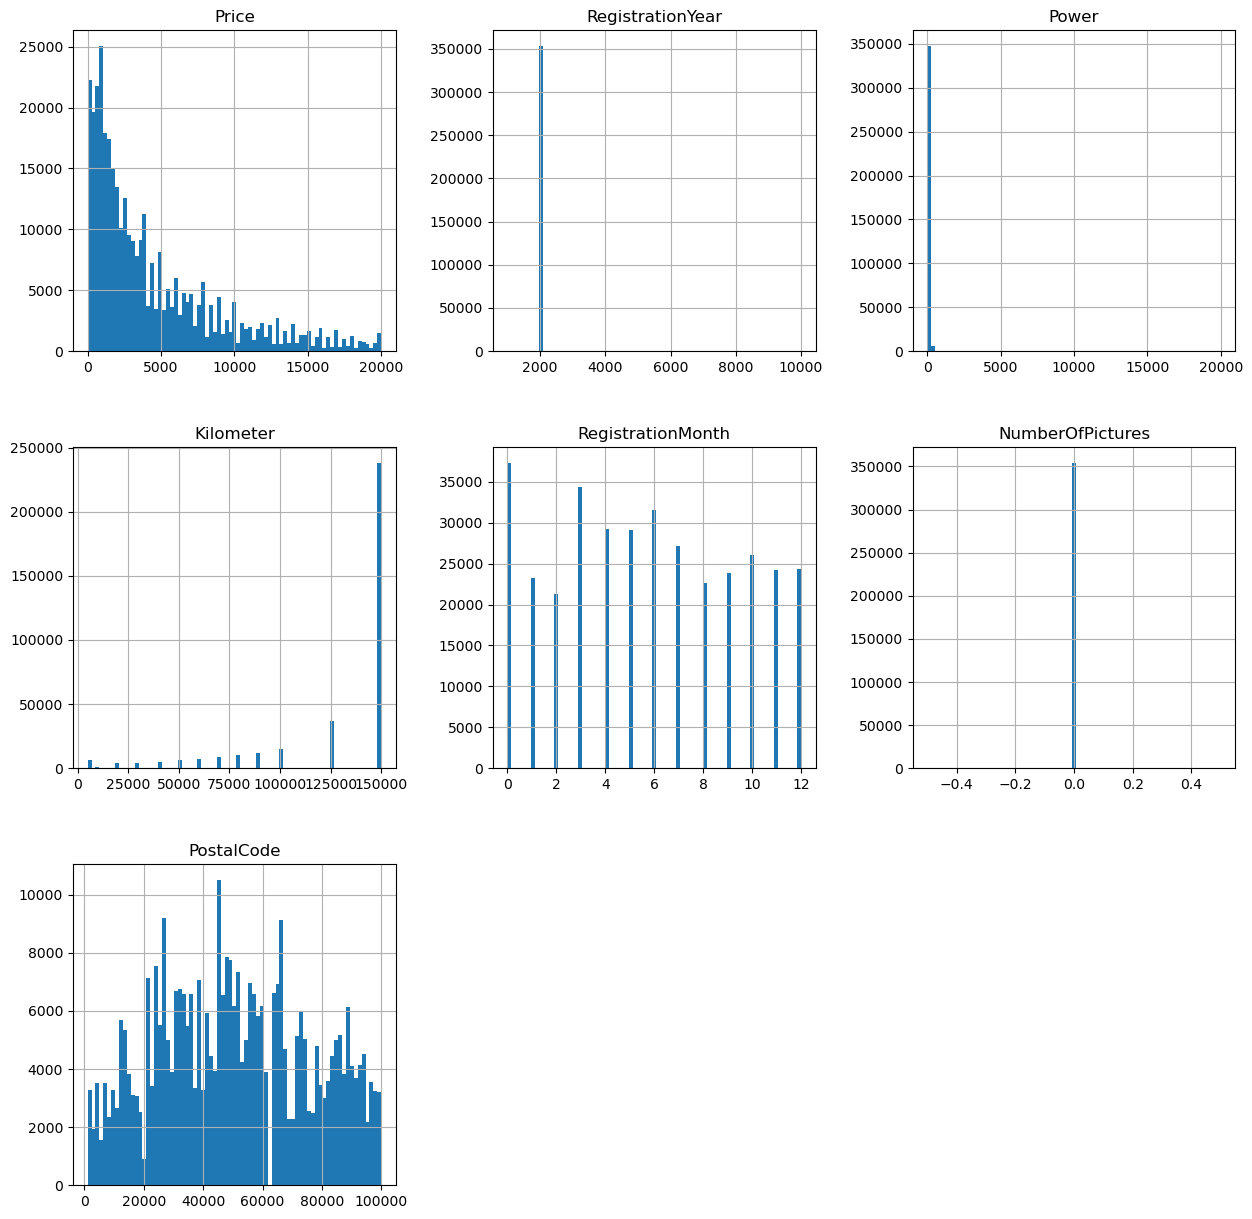

In [8]:
df.hist(figsize=(15,15), bins=75);

In [9]:
(df.isna().mean() * 100).round(2)

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
Repaired             20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

In [10]:
df.duplicated().sum()

4

#### Вывод

В данных присутствуют пропуски, выбросы и дубликаты.

### Предобработка данных

Создадим копию исходного датафрейма.

In [11]:
df_original = df

#### Переименовываем столбцы

In [12]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Все слова в названии столбцов написаны слитно и с заглавной буквы.<br>
Тогда, напишем функцию с циклом, которая будет:
 1. перебирать названия столбцов,
 2. находить заглавные буквы и ставить _ перед ними,
 3. приводить заглавные буквы к нижнему регистру,
 4. удалять все _ в начале названия каждого столбца,
 5. заменять все __ на _.

In [13]:
def columns_rename(temp):
    for i in range(len(temp)):
        temp[i] = re.sub(r"([A-Z])", lambda x: '_' + x.group(0).lower(), str(temp[i]))
        if temp[i][0] == "_":
            temp[i] = temp[i][1:]
        if "__" in temp[i]:
            temp[i] = re.sub(r"__", lambda x: '_', str(temp[i]))
    return temp

df.columns = columns_rename(df.columns.tolist())
df.sample(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
40254,2016-03-28 19:25:38,7000,wagon,1996,manual,190,golf,150000,0,NaN,volkswagen,NaN,2016-03-28 00:00:00,0,35708,2016-04-01 08:17:47
280090,2016-03-16 19:37:44,2999,bus,1999,manual,90,transporter,150000,7,gasoline,volkswagen,no,2016-03-16 00:00:00,0,34130,2016-03-19 17:47:41
307988,2016-03-14 01:06:25,7480,convertible,2006,manual,90,one,150000,5,petrol,mini,no,2016-03-13 00:00:00,0,56412,2016-04-06 17:15:44
318703,2016-03-29 10:36:22,1700,convertible,1984,manual,29,other,150000,10,petrol,citroen,no,2016-03-29 00:00:00,0,59199,2016-03-29 10:36:22
90206,2016-04-01 07:55:49,5500,NaN,2016,manual,200,golf,150000,0,NaN,volkswagen,no,2016-04-01 00:00:00,0,57413,2016-04-01 09:42:45


#### Удаляем дубликаты

In [14]:
df = df.drop_duplicates().reset_index(drop = True)

Оценим неявные дубликаты:

In [15]:
for column in df[list(df.select_dtypes(include=['object']).columns)].columns:
    print(df[column].sort_values().unique())

['2016-03-05 14:06:22' '2016-03-05 14:06:23' '2016-03-05 14:06:24' ...
 '2016-04-07 14:36:55' '2016-04-07 14:36:56' '2016-04-07 14:36:58']
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
['auto' 'manual' nan]
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_kl

#### Приведем значения date_crawled, date_created, last_seen к типу данных datetime

In [16]:
columns_to_datetime = {
    'date_crawled':df,
    'date_created':df,
    'last_seen':df
}

for column, frame in columns_to_datetime.items():
    frame[column] = pd.to_datetime(frame[column],format = '%Y-%m-%d %H:%M:%S')

#### Оценим столбец price

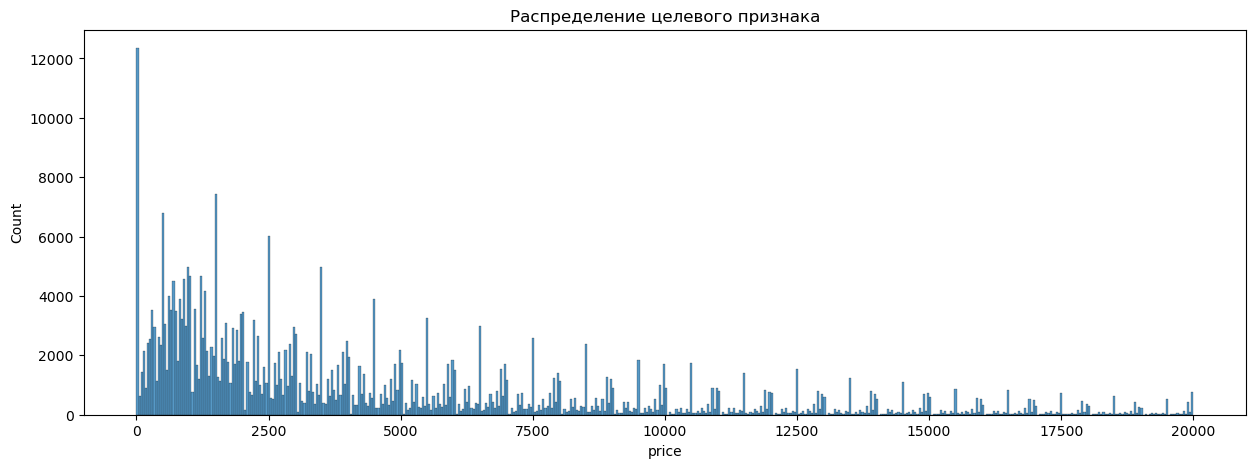

In [17]:
plt.figure(figsize=(15,5))
plt.title('Распределение целевого признака')
sns.histplot(df['price'], bins=500);

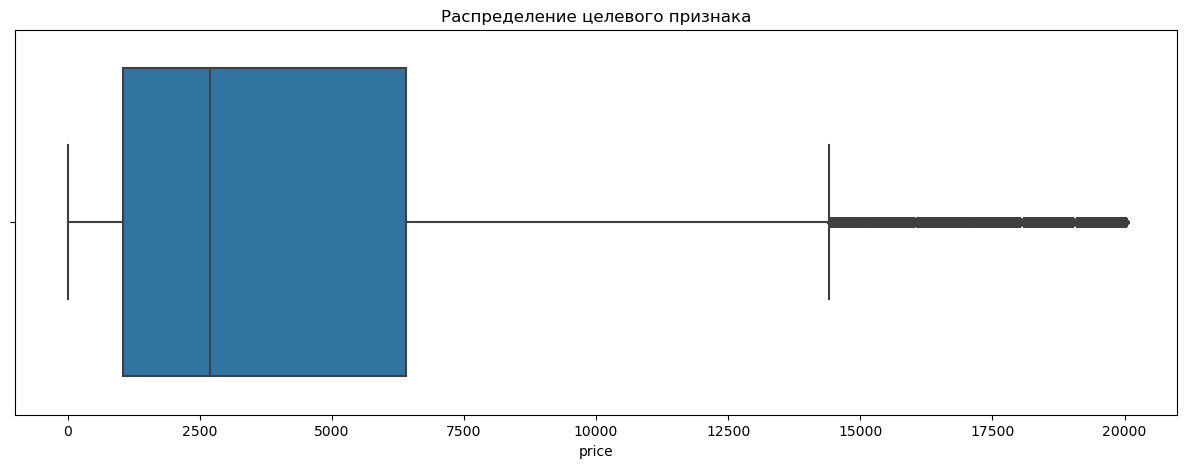

In [18]:
plt.figure(figsize=(15,5))
plt.title('Распределение целевого признака')
sns.boxplot(x=df['price']);

Есть некоторая цикличность в пиках, скорее всего это связано с тем, что люди выставляя цену округляют до целых чисел 2-ого, 3-его, 4-ого и т.д. порядков (т.е. 100, 1000, 10000 и т.д.)  
Есть выбросы в области увеличения цены, создающие нам высокое стандартное отклонение.  
Есть аномальные значения в области 0. Давайте посмотри сколько их.

In [19]:
df[df['price'] <= 10].value_counts().sum()

3753

Значения обладают высоким стандартным отклонением, что может сказаться на точности модели.  
Так же есть значения цены равные 0 и 1. Я допускаю, что такое возможно, но скорее всего это ошибка, либо намеренно допущенная пользователем, при заполнении объявления, либо получившаяся при некорректной выгрузки базы.

In [20]:
df = df.query('price >= 10')

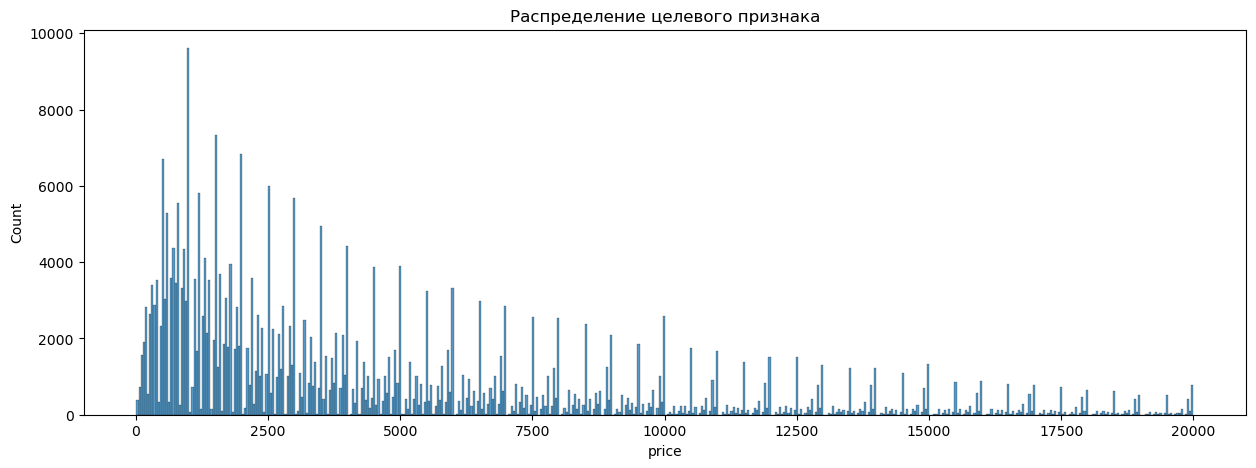

In [21]:
plt.figure(figsize=(15,5))
plt.title('Распределение целевого признака')
sns.histplot(df['price'], bins=500);

#### Заполним пропуски в столбцах vehicle_type, gearbox, model, fuel_type и repaired

In [22]:
df[df['vehicle_type'].isna()].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07


In [23]:
df['vehicle_type'].isna().sum()

33249

In [24]:
df['vehicle_type'].value_counts()

sedan          89197
small          77838
wagon          63544
bus            28280
convertible    19826
coupe          15574
suv            11769
other           3060
Name: vehicle_type, dtype: int64

Были мысли попробовать восстановить данные столбца vehicle_type с помощью функции mode по столбцам brand и model. Но высока вероятность внесения синтетических данных. Поэтому поставим заглушку "n/d" (от no data) вместо всех пропусков.

In [25]:
df = df.fillna('n/d')

#### Обработаем данные в столбцах registration_year и registration_month

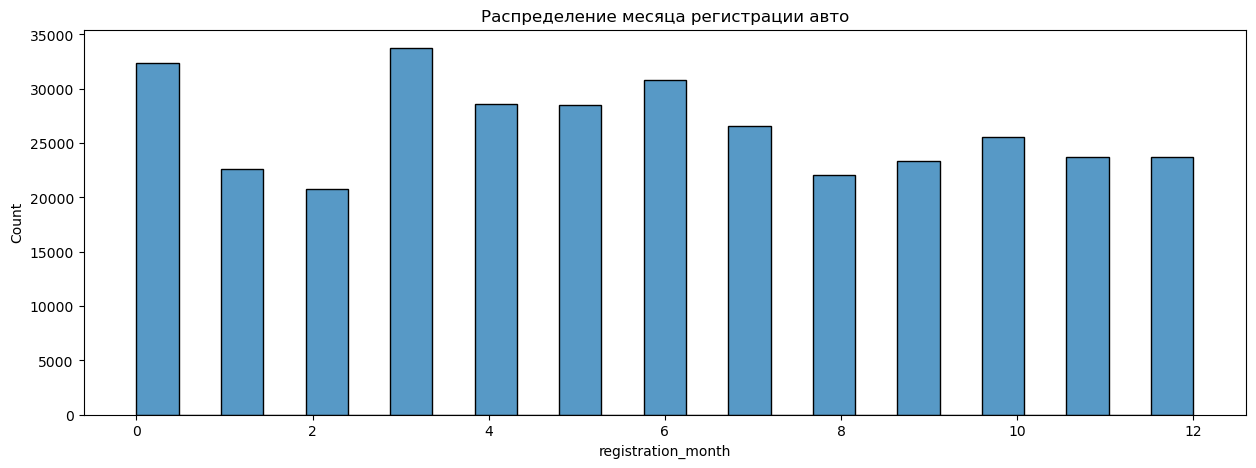

In [26]:
plt.figure(figsize=(15,5))
plt.title('Распределение месяца регистрации авто')
sns.histplot(df['registration_month'], bins=25);

Распределение месяца регистрации авто, вероятно, ведется от 1 до 12, т.е. 1 - январь, 2 - февраль и т.д. Присутствуют аномальные значения - 0. По графику можно визуально определить, что данных достаточно много. Удаление такого объема строк нежелательно, т.к. повлечет и удаление потенциально полезных данных. 

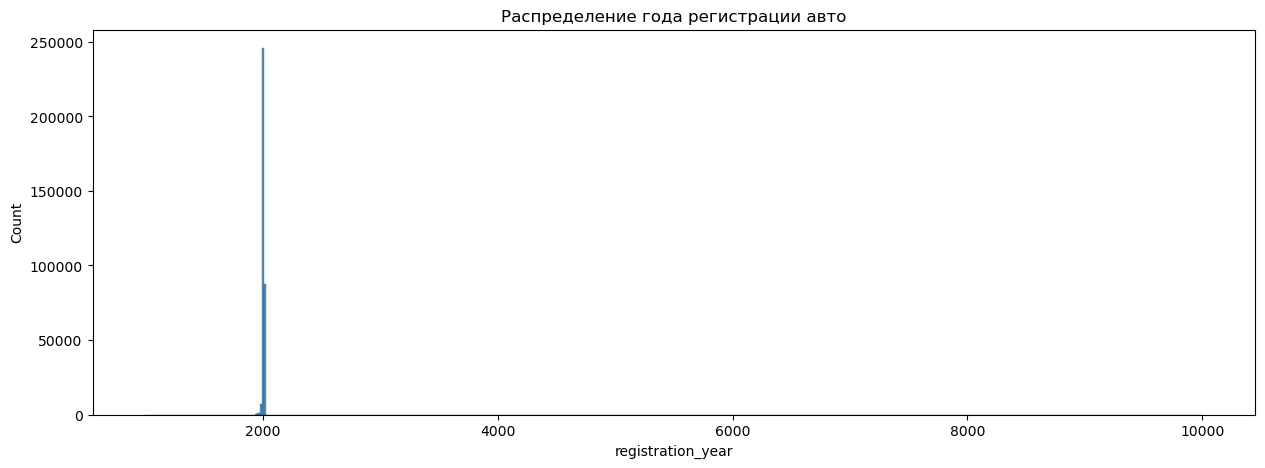

In [27]:
plt.figure(figsize=(15,5))
plt.title('Распределение года регистрации авто')
sns.histplot(df['registration_year'], bins=500);

In [28]:
df['registration_year'].value_counts()

2000    22889
1999    21904
2005    21447
2006    19661
2001    19594
        ...  
3700        1
3800        1
4800        1
2290        1
1946        1
Name: registration_year, Length: 139, dtype: int64

Укрупним график, ограничив с 1950 по 2020 года.

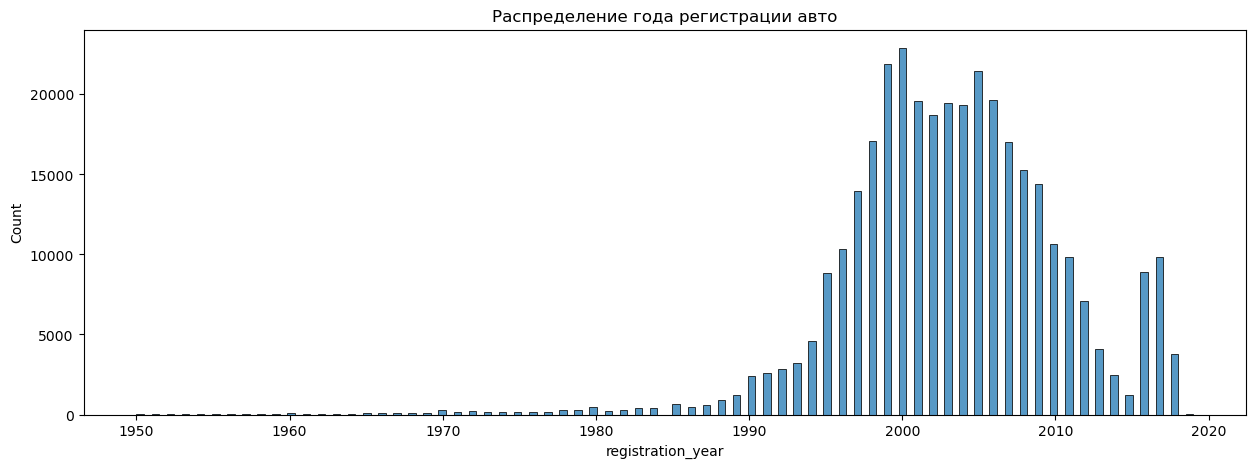

In [29]:
plt.figure(figsize=(15,5))
plt.title('Распределение года регистрации авто')
sns.histplot(df['registration_year'].loc[(df['registration_year'] <= 2020) & (df['registration_year'] >= 1950)], bins=140);

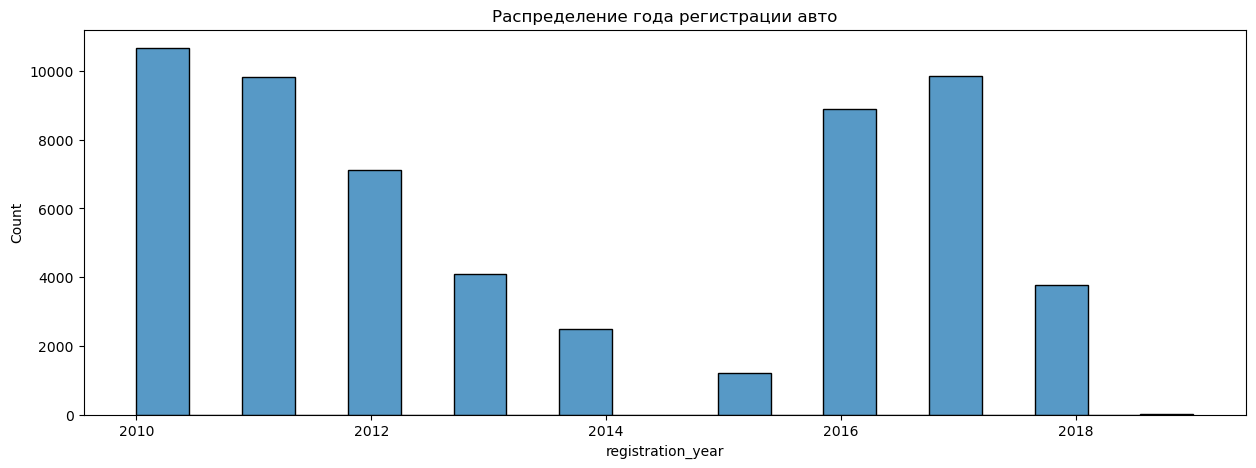

In [30]:
plt.figure(figsize=(15,5))
plt.title('Распределение года регистрации авто')
sns.histplot(df['registration_year'].loc[(df['registration_year'] <= 2020) & (df['registration_year'] >= 2010)], bins=20);

С 1960 по 2015 года распределение выглядит нормально. Присутствуют единичные выбросы и аномалия данных в 2016, 2017 и 2018 годах. Выбросы мы почистим, а вот аномалию постараемся изучить отдельно. Для этого найдем дату среза базы данных. У нас есть 3 столбца в формате datetime. Найдем самую старую дату, в этих столбцах, это будет дата последней активности перед срезом базы. Грубо, ее можно считать датой среза базы. Строчки с данными можно считать аномальными, если дата регистрации авто окажется старше даты среза базы данных.

In [31]:
df = df.query('registration_year >= 1960')

In [32]:
slice_date = df['date_crawled'].max()
if df['date_created'].max() > slice_date:
    slice_date = df['date_created'].max()
if df['last_seen'].max() > slice_date:
    slice_date = df['last_seen'].max()

slice_date

Timestamp('2016-04-07 14:58:51')

In [33]:
temp_y = int(slice_date.strftime('%Y'))
temp_m = int(slice_date.strftime('%m'))
temp_y, temp_m

(2016, 4)

Удалим аномальные данные.

In [34]:
del_index = []
for index_value, value_y, value_m in zip(df['price'].index, df['registration_year'], df['registration_month']):
    if (value_y > temp_y) or ((value_y == temp_y) and (value_m > temp_m)):
        del_index.append(index_value)
df = df.drop(del_index,axis = 0)

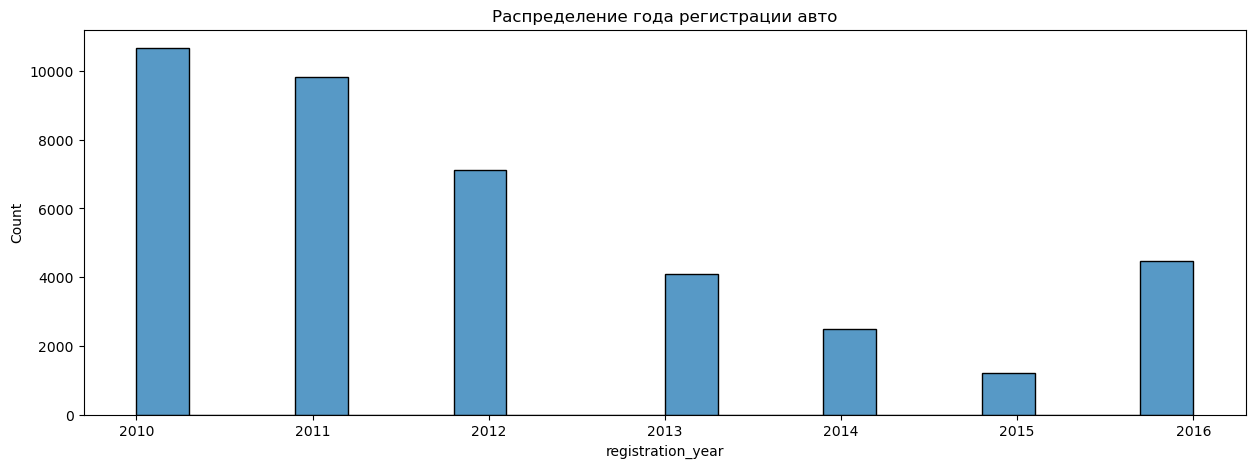

In [35]:
plt.figure(figsize=(15,5))
plt.title('Распределение года регистрации авто')
sns.histplot(df['registration_year'].loc[(df['registration_year'] <= 2020) & (df['registration_year'] >= 2010)], bins=20);

#### Обработаем данные в столбцах power

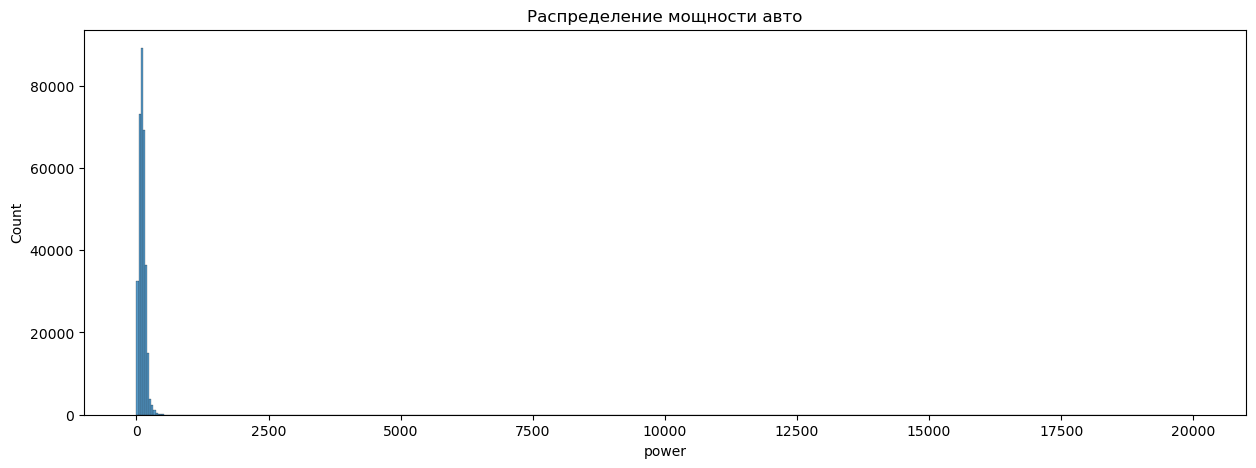

In [36]:
plt.figure(figsize=(15,5))
plt.title('Распределение мощности авто')
sns.histplot(df['power'], bins=500);

In [37]:
q10=np.array(df['power'].quantile(0.1))
q90=np.array(df['power'].quantile(0.9))
first_part=q10-1.5*(q90-q10)
second_part=q90+1.5*(q90-q10)
del_index = []
for index_value, value in zip(df['power'].index,df['power']):
    if second_part <= value or value <= first_part or value <= 1:
        del_index.append(index_value)
df = df.drop(del_index,axis = 0)

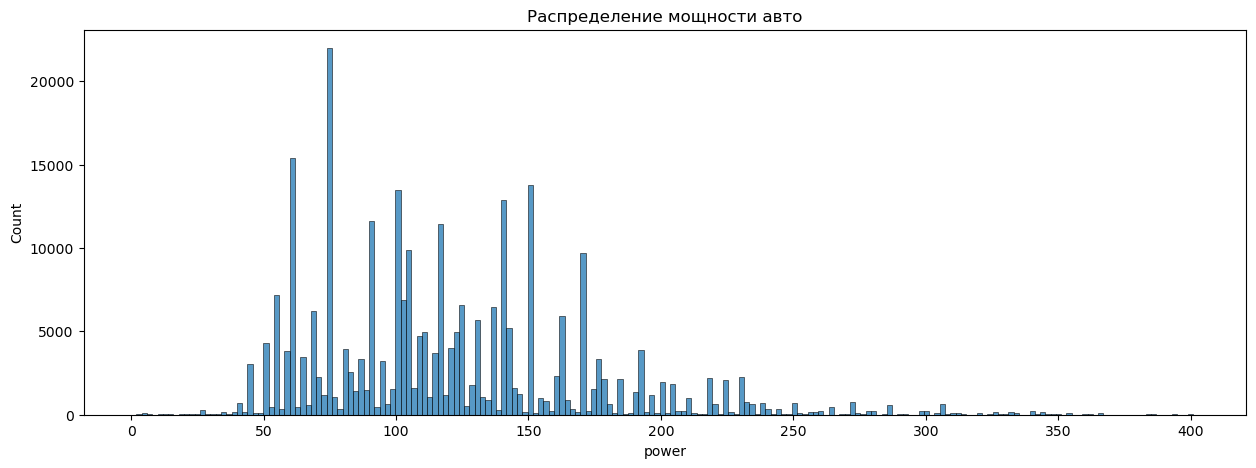

In [38]:
plt.figure(figsize=(15,5))
plt.title('Распределение мощности авто')
sns.histplot(df['power'], bins=200);

#### Оценим столбец kilometer

In [39]:
df['kilometer'].value_counts(), len(df['kilometer'].value_counts())

(150000    193273
 125000     31451
 100000     12693
 90000      10226
 80000       8946
 70000       7742
 60000       6793
 50000       5626
 40000       4493
 30000       3892
 20000       3255
 5000        2744
 10000        917
 Name: kilometer, dtype: int64,
 13)

Столбец категориальный с типом данных целых чисел, с ним ничего делать не надо.

#### Оценим столбец number_of_pictures и postal_code

In [40]:
df['number_of_pictures'].value_counts(), len(df['number_of_pictures'].value_counts())

(0    292051
 Name: number_of_pictures, dtype: int64,
 1)

In [41]:
df['postal_code'].value_counts(), len(df['postal_code'].value_counts())

(10115    798
 65428    501
 66333    270
 60311    260
 52525    247
         ... 
 72361      1
 67693      1
 63874      1
 31719      1
 95691      1
 Name: postal_code, Length: 8113, dtype: int64,
 8113)

Столбец number_of_pictures содержит единственное значение - 0. Он не окажет никакого влияние на исследование, поэтому его можно удалять.  
Очень похоже, что столбец postal_code содежит почтовые индексы городов Германии. Можно выдвинуть гипотезу, что на целевой признак может влиять географическое расположение пользователя. Мы знаем, что в разных частям мира существует разный уровень экономического развития и жизни населения. Из этого следует, что один и тот же предмет может стоить по разному в разных местах. (живой пример - индек бигмака). Следуя этой теории, можно было бы обобщить столбец (привязать почтовые индексы к федеральному делению Германии) и рассматривать его как признак, влияющий на целевой признак. Но, я полагаю, что в данном случае, влияния практически не будет, цена авто будет уравновешана механизмами рыночной экономики внутри страны. Но мы всеравно попробуем реализовать гипотезу чтобы просто сохранить больше исходных данных. 

Функция группирует почтовые индексы по географическому признаку на основе данных с сайта: https://postal-codes.cybo.com/germany/

In [42]:
def pcz(row):
    if row['postal_code'] >= 8056 and row['postal_code'] <= 9669:
        val = "Saxony"
    elif row['postal_code'] >= 1067 and row['postal_code'] <= 4889:
        val = "Saxony"
    elif row['postal_code'] >= 3042 and row['postal_code'] <= 3253:
        val = "Brandenburg"
    elif row['postal_code'] >= 14461 and row['postal_code'] <= 17326:
        val = "Brandenburg"
    elif row['postal_code'] >= 6108 and row['postal_code'] <= 6928:
        val = "Saxony-Anhalt"
    elif row['postal_code'] >= 38820 and row['postal_code'] <= 39649:
        val = "Saxony-Anhalt"
    elif row['postal_code'] >= 7318 and row['postal_code'] <= 7989:
        val = "Thuringia"
    elif row['postal_code'] >= 98527 and row['postal_code'] <= 99998:
        val = "Thuringia"
    elif row['postal_code'] >= 10115 and row['postal_code'] <= 14532:
        val = "Berlin"
    elif row['postal_code'] >= 17033 and row['postal_code'] <= 19417:
        val = "Mecklenburg-Vorpommern"
    elif row['postal_code'] >= 20038 and row['postal_code'] <= 21149:
        val = "Hamburg"
    elif row['postal_code'] >= 22041 and row['postal_code'] <= 22769:
        val = "Hamburg"
    elif row['postal_code'] >= 21217 and row['postal_code'] <= 21789:
        val = "Lower Saxony"
    elif row['postal_code'] >= 26121 and row['postal_code'] <= 38729:
        val = "Lower Saxony"
    elif row['postal_code'] >= 49074 and row['postal_code'] <= 49849:
        val = "Lower Saxony"
    elif row['postal_code'] >= 22844 and row['postal_code'] <= 25999:
        val = "Schleswig-Holstein"
    elif row['postal_code'] >= 27568 and row['postal_code'] <= 27580:
        val = "Bremen (state)"
    elif row['postal_code'] >= 28195 and row['postal_code'] <= 28779:
        val = "Bremen (state)"
    elif row['postal_code'] >= 32049 and row['postal_code'] <= 33829:
        val = "North Rhine-Westphalia"
    elif row['postal_code'] >= 40196 and row['postal_code'] <= 54585:
        val = "North Rhine-Westphalia"
    elif row['postal_code'] >= 58084 and row['postal_code'] <= 59969:
        val = "North Rhine-Westphalia"
    elif row['postal_code'] >= 34117 and row['postal_code'] <= 37299:
        val = "Hesse"
    elif row['postal_code'] >= 60306 and row['postal_code'] <= 63699:
        val = "Hesse"
    elif row['postal_code'] >= 64283 and row['postal_code'] <= 65936:
        val = "Hesse"
    elif row['postal_code'] >= 54290 and row['postal_code'] <= 57648:
        val = "Rhineland-Palatinate"
    elif row['postal_code'] >= 66849 and row['postal_code'] <= 67829:
        val = "Rhineland-Palatinate"
    elif row['postal_code'] >= 66041 and row['postal_code'] <= 66839:
        val = "Saarland"
    elif row['postal_code'] >= 68131 and row['postal_code'] <= 79879:
        val = "Baden-Württemberg"
    elif row['postal_code'] >= 88212 and row['postal_code'] <= 89198:
        val = "Baden-Württemberg"
    elif row['postal_code'] >= 80331 and row['postal_code'] <= 97909:
        val = "Bavaria"
    elif row['postal_code'] >= 63739 and row['postal_code'] <= 63939:
        val = "Bavaria"
    elif row['postal_code'] >= 97922 and row['postal_code'] <= 97999:
        val = "Baden-Württemberg"
    elif row['postal_code'] >= 4895 and row['postal_code'] <= 4938:
        val = "Brandenburg"
    else :
        val = 'n/d'
    return val

In [43]:
df['postal_code_zone'] = df.apply(pcz, axis=1)

In [44]:
df['postal_code_zone'].value_counts()

North Rhine-Westphalia    60632
Lower Saxony              55484
Bavaria                   45609
Baden-Württemberg         33835
Hesse                     16715
Rhineland-Palatinate      16669
Berlin                    11916
Schleswig-Holstein        11078
Saxony                     9736
Brandenburg                6756
Hamburg                    5597
Saxony-Anhalt              5304
Saarland                   5051
Thuringia                  4550
Mecklenburg-Vorpommern     3119
Name: postal_code_zone, dtype: int64

#### Удаляем столбцы и проверяем корреляцию признаков

Удаление number_of_pictures и postal_code мы уже аргументировали выше.  
Столбцы date_crawled, date_created и last_seen тоже не окажут никакого влияния на иследование.

In [45]:
df = df.drop(['number_of_pictures', 'postal_code', 'date_crawled', 'date_created', 'last_seen'], axis=1)

Проверим корреляцию и мультиколлинеарность признаков.

In [46]:
df.corr()

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,price,registration_year,power,kilometer,registration_month
price,1.000000,0.520967,0.508618,-0.389198,0.072132
registration_year,0.520967,1.000000,0.149251,-0.313157,0.032604
power,0.508618,0.149251,1.000000,0.109612,0.044639
kilometer,-0.389198,-0.313157,0.109612,1.000000,-0.017100
registration_month,0.072132,0.032604,0.044639,-0.017100,1.000000


коэф Пирсона показывает умеренную корреляцию целевого признака с признаками registration_year и power.

In [47]:
df_vif = df[df.select_dtypes(include=['int64']).columns]

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif['variable'] = df_vif.columns
vif

,VIF,variable
0,3.950259,price
1,22.566824,registration_year
2,9.882751,power
3,18.202557,kilometer
4,3.792410,registration_month


коэф инфляции дисперсии (VIF) показывает умеренную корреляцию целевого признака, при этом мы наблюдаем высокую мультиколлинеарность остальных признаков.

In [48]:
df = df.drop(['registration_month'], axis=1)

#### Преобразование категориальных признаков в численные и формирование выборок

In [49]:
list(df.select_dtypes(include=['object']).columns)

['vehicle_type',
 'gearbox',
 'model',
 'fuel_type',
 'brand',
 'repaired',
 'postal_code_zone']

Я вижу 2 варианта преобразования:  
    1). Прямое кодирование (One-Hot Encoding, OHE)  
    2). Порядковое кодирование (Ordinal Encoding, OE)  
      
Предлагаю реализовать оба способа и в конце сравнить результаты.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292051 entries, 1 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              292051 non-null  int64 
 1   vehicle_type       292051 non-null  object
 2   registration_year  292051 non-null  int64 
 3   gearbox            292051 non-null  object
 4   power              292051 non-null  int64 
 5   model              292051 non-null  object
 6   kilometer          292051 non-null  int64 
 7   fuel_type          292051 non-null  object
 8   brand              292051 non-null  object
 9   repaired           292051 non-null  object
 10  postal_code_zone   292051 non-null  object
dtypes: int64(4), object(7)
memory usage: 26.7+ MB


Разобьем датафрейм на выборки: обучающую и тестовую.

In [51]:
features = df.drop(['price'], axis=1)
target = df['price']

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=rs)

In [52]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(219038, 10)
(73013, 10)
(219038,)
(73013,)


##### One-Hot Encoding, OHE

In [53]:
df_ohe = pd.get_dummies(
    df,
    columns = df.select_dtypes(include = ['object']).columns,
    drop_first = True
)

In [54]:
features_ohe = df_ohe.drop(['price'], axis=1)
target_ohe = df_ohe['price']

features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(
    features_ohe,
    target_ohe,
    test_size=0.25,
    random_state=rs)

In [55]:
print(features_ohe_train.shape)
print(features_ohe_test.shape)
print(target_ohe_train.shape)
print(target_ohe_test.shape)

(219038, 324)
(73013, 324)
(219038,)
(73013,)


##### Ordinal Encoding, OE

In [56]:
encoder = OrdinalEncoder()
df_oe = df
df_oe[list(df.select_dtypes(include = ['object']).columns)] = encoder.fit_transform(df_oe[list(df.select_dtypes(include=['object']).columns)])

In [57]:
features_oe = df_oe.drop(['price'], axis=1)
target_oe = df_oe['price']

features_oe_train, features_oe_test, target_oe_train, target_oe_test = train_test_split(
    features_oe,
    target_oe,
    test_size=0.25,
    random_state=rs)

In [58]:
print(features_oe_train.shape)
print(features_oe_test.shape)
print(target_oe_train.shape)
print(target_oe_test.shape)

(219038, 10)
(73013, 10)
(219038,)
(73013,)


#### Вывод

Мы заполнили пропуски и удалили выбросы в данных. Проверили корреляцию признаков, она в норме. Преобразовали категориальные признаки в численные с помощью Ordinal Encoding и One-Hot Encoding. Разделили данные на обучающую и тестовую выборки.

## Обучение моделей

Создадим таблицу с результатами обучения для каждой модели. Результаты будут отражать важные для заказчика параметры: время обучения, скорость и качество предсказания. Для идентификации модели добавим название модели, метод преобразования категориальных признаков и параметры модели.

In [59]:
models = pd.DataFrame(columns =  ['model_name', 'encoder', 'model_var', 'fit_time', 'predict_time', 'full_time', 'rmse_train'])
display(models)

,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train


Напишим функцию, которая будет сохранять результаты обучения модели в итоговую таблицу.

In [60]:
def models_result (model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models):
    result = [model_name, encoder, model_var, fit_time, predict_time, full_time, rmse]
    rows = [pd.Series(result, index = models.columns)]
    models = models.append(rows,ignore_index=True)
    return(models)

Напишим функцию, которая будет считать точность модели по среднеквадратической ошибке (RMSE).

In [61]:
def rmse_scorer(target: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mean_squared_error(target, predicted))

rmse_scoring = make_scorer(rmse_scorer, greater_is_better=False)

Напишим функцию, обучения и предсказания точности модели с расчетом потраченного времени.
 - мы будем расставлять временные маркеры в начале и конце обучения и предсказания модели с помощью функции time.time()
 - находя разницу между значениями маркетов, мы получим затраченное время на обучения и предсказание модели
 - определим точность модели с помощью функции нахождения среднеквадратичной ошибки

In [62]:
def fit_model(model, features_train, target_train):

    rmse = round(np.mean(np.sqrt(np.abs(cross_val_score(model, features_train, target_train, scoring="neg_mean_squared_error")))), 2)
    
    fit_start = time.time()
    model.fit(features_train, target_train)
    fit_time = round(time.time() - fit_start, 1)

    predict_start = time.time()
    predicted_train = model.predict(features_train)
    predict_time = round(time.time() - predict_start, 1)
    
    train_time = fit_time + predict_time

    return(rmse, fit_time, predict_time, train_time)

### Linear Regression

Масштабируем численные признаки для линейных моделей:

In [63]:
numeric = list(df_ohe.select_dtypes(include=['int64']).columns)
numeric.remove('price')
numeric

['registration_year', 'power', 'kilometer']

In [64]:
features_lr_ohe_train = features_ohe_train.copy()
features_lr_ohe_test = features_ohe_test.copy()

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_lr_ohe_train[numeric] = scaler.transform(features_ohe_train[numeric])
features_lr_ohe_test[numeric] = scaler.transform(features_ohe_test[numeric])

In [65]:
model_lr = LinearRegression()
model_name = "Linear Regression"

#### Обучаем и предсказываем на выборке OHE

In [66]:
encoder = "OHE"
model_var = np.nan

In [67]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_lr,
    features_lr_ohe_train, 
    target_ohe_train)

CPU times: total: 1min 7s
Wall time: 13.9 s


In [68]:
models = models_result(model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models)
models

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\2072501531.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78


### Decision Tree

In [69]:
model_dt = DecisionTreeRegressor(random_state = rs)
model_name = "Decision Tree"

#### Обучаем и предсказываем на выборке OHE

In [70]:
encoder = "OHE"
param_dt_ohe = {
#    'max_depth': range(1, 50, 1),    
    'max_depth': [14],
    'random_state': [rs]
} 

In [71]:
grid_dt_ohe = GridSearchCV(
    estimator = model_dt,
    param_grid = param_dt_ohe,
    scoring = rmse_scoring,
    cv = 3)

In [72]:
%%time
grid_dt_ohe.fit(features_ohe_train, target_ohe_train)
grid_dt_ohe.best_params_

CPU times: total: 13.5 s
Wall time: 12.7 s


{'max_depth': 14, 'random_state': 12345}

In [73]:
model_dt_ohe = DecisionTreeRegressor(**grid_dt_ohe.best_params_)

In [74]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_dt_ohe,
    features_ohe_train, 
    target_ohe_train)

CPU times: total: 21.1 s
Wall time: 21 s


In [75]:
model_var = grid_dt_ohe.best_params_
del model_var['random_state']
model_var

{'max_depth': 14}

In [76]:
models = models_result(model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models)
models

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\2072501531.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78
1,Decision Tree,OHE,{'max_depth': 14},3.9,0.3,4.2,1857.22


#### Обучаем и предсказываем на выборке OE

In [77]:
encoder = "OE"
param_dt_oe = {
#    'max_depth': range(1, 50, 1),    
    'max_depth': [14],
    'random_state': [rs]
}

In [78]:
grid_dt_oe = GridSearchCV(
    estimator = model_dt,
    param_grid = param_dt_oe,
    scoring = rmse_scoring,
    cv = 3)

In [79]:
%%time
grid_dt_oe.fit(features_oe_train, target_oe_train)
grid_dt_oe.best_params_

CPU times: total: 1.67 s
Wall time: 1.7 s


{'max_depth': 14, 'random_state': 12345}

In [80]:
model_dt_oe = DecisionTreeRegressor(**grid_dt_oe.best_params_)

In [81]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_dt_oe,
    features_oe_train, 
    target_oe_train,
)

CPU times: total: 2.88 s
Wall time: 2.93 s


In [82]:
model_var = grid_dt_oe.best_params_
del model_var['random_state']
model_var

{'max_depth': 14}

In [83]:
models = models_result(model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models)
models

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\2072501531.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78
1,Decision Tree,OHE,{'max_depth': 14},3.9,0.3,4.2,1857.22
2,Decision Tree,OE,{'max_depth': 14},0.5,0.0,0.5,1859.73


### Random Forest

In [84]:
model_rf = RandomForestRegressor(random_state = rs)
model_name = "Random Forest"

#### Обучаем и предсказываем на выборке OHE

In [85]:
encoder = "OHE"
param_rf_ohe = {
#    'n_estimators': range(1, 51, 1),
    'n_estimators': [50],
#    'max_depth': range(1, 25, 1),
    'max_depth': [24],
    'random_state': [rs]
}

In [86]:
grid_rf_ohe = GridSearchCV(
    estimator = model_rf,
    param_grid = param_rf_ohe,
    scoring = rmse_scoring,
)

In [87]:
%%time
grid_rf_ohe.fit(features_ohe_train, target_ohe_train)
grid_rf_ohe.best_params_

CPU times: total: 14min 51s
Wall time: 14min 50s


{'max_depth': 24, 'n_estimators': 50, 'random_state': 12345}

In [88]:
model_rf_ohe = RandomForestRegressor(**grid_rf_ohe.best_params_)

In [89]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_rf_ohe,
    features_ohe_train, 
    target_ohe_train
)

CPU times: total: 14min 59s
Wall time: 14min 57s


In [90]:
model_var = grid_rf_ohe.best_params_
del model_var['random_state']
model_var

{'max_depth': 24, 'n_estimators': 50}

In [91]:
models = models_result(model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models)
models

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\2072501531.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78
1,Decision Tree,OHE,{'max_depth': 14},3.9,0.3,4.2,1857.22
2,Decision Tree,OE,{'max_depth': 14},0.5,0.0,0.5,1859.73
3,Random Forest,OHE,"{'max_depth': 24, 'n_estimators': 50}",182.4,4.1,186.5,1563.52


#### Обучаем и предсказываем на выборке OE

In [92]:
encoder = "OE"
param_rf_oe = {
#    'n_estimators': range(1, 51, 1),
    'n_estimators': [50],
#    'max_depth': range(1, 25, 1),
    'max_depth': [20],
    'random_state': [rs]
}

In [93]:
grid_rf_oe = GridSearchCV(
    estimator = model_rf,
    param_grid = param_rf_oe,
    scoring = rmse_scoring,
)

In [94]:
%%time
grid_rf_oe.fit(features_oe_train, target_oe_train)
grid_rf_oe.best_params_

CPU times: total: 3min 7s
Wall time: 3min 6s


{'max_depth': 20, 'n_estimators': 50, 'random_state': 12345}

In [95]:
model_rf_oe = RandomForestRegressor(**grid_rf_oe.best_params_)

In [96]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_rf_oe,
    features_oe_train, 
    target_oe_train,
)

CPU times: total: 3min 6s
Wall time: 3min 7s


In [97]:
model_var = grid_rf_oe.best_params_
del model_var['random_state']
model_var

{'max_depth': 20, 'n_estimators': 50}

In [98]:
models = models_result(model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models)
models

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\2072501531.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78
1,Decision Tree,OHE,{'max_depth': 14},3.9,0.3,4.2,1857.22
2,Decision Tree,OE,{'max_depth': 14},0.5,0.0,0.5,1859.73
3,Random Forest,OHE,"{'max_depth': 24, 'n_estimators': 50}",182.4,4.1,186.5,1563.52
4,Random Forest,OE,"{'max_depth': 20, 'n_estimators': 50}",35.5,2.6,38.1,1570.08


### XGBoost

In [99]:
model_xgb = XGBRegressor(random_state = rs)
model_name = "XGBoost"

#### Обучаем и предсказываем на выборке OHE

In [100]:
encoder = "OHE"
parameters_xgb_ohe = {
    'learning_rate': [0.1],
#    'max_depth': range(1, 25, 1),
    'max_depth': [14],
    'subsample': [0.5],
    'random_state': [rs]
}

In [101]:
grid_xgb_ohe = GridSearchCV(
    estimator = model_xgb, 
    param_grid = parameters_xgb_ohe, 
    scoring = rmse_scoring, 
    cv = 3, 
    n_jobs = -1, 
    verbose = 1
)

In [102]:
%%time
grid_xgb_ohe.fit(features_ohe_train, target_ohe_train)
grid_xgb_ohe.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: total: 16min 24s
Wall time: 9min 18s


{'learning_rate': 0.1,
 'max_depth': 14,
 'random_state': 12345,
 'subsample': 0.5}

In [103]:
model_xgb_ohe = XGBRegressor(**grid_xgb_ohe.best_params_) 

In [104]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_xgb_ohe,
    features_ohe_train, 
    target_ohe_train
)

CPU times: total: 1h 21min 24s
Wall time: 7min 30s


In [105]:
model_var = grid_xgb_ohe.best_params_
del model_var['random_state']
model_var

{'learning_rate': 0.1, 'max_depth': 14, 'subsample': 0.5}

In [106]:
models = models_result(model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models)
models

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\2072501531.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78
1,Decision Tree,OHE,{'max_depth': 14},3.9,0.3,4.2,1857.22
2,Decision Tree,OE,{'max_depth': 14},0.5,0.0,0.5,1859.73
3,Random Forest,OHE,"{'max_depth': 24, 'n_estimators': 50}",182.4,4.1,186.5,1563.52
4,Random Forest,OE,"{'max_depth': 20, 'n_estimators': 50}",35.5,2.6,38.1,1570.08
5,XGBoost,OHE,"{'learning_rate': 0.1, 'max_depth': 14, 'subsa...",88.4,0.5,88.9,1511.33


#### Обучаем и предсказываем на выборке OE

In [107]:
encoder = "OE"
parameters_xgb_oe = {
    'learning_rate': [0.1],
#    'max_depth': range(1, 25, 1),
    'max_depth': [14],
    'subsample': [0.5],
    'random_state': [rs]
}

In [108]:
grid_xgb_oe = GridSearchCV(
    estimator = model_xgb, 
    param_grid = parameters_xgb_oe, 
    scoring = rmse_scoring, 
    cv = 3, 
    n_jobs = -1, 
    verbose = 1
)

In [109]:
%%time
grid_xgb_oe.fit(features_oe_train, target_oe_train)
grid_xgb_oe.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: total: 2min 3s
Wall time: 46.9 s


{'learning_rate': 0.1,
 'max_depth': 14,
 'random_state': 12345,
 'subsample': 0.5}

In [110]:
model_xgb_oe = XGBRegressor(**grid_xgb_oe.best_params_) 

In [111]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_xgb_oe,
    features_oe_train, 
    target_oe_train,
)

CPU times: total: 10min 18s
Wall time: 57.1 s


In [112]:
model_var = grid_xgb_oe.best_params_
del model_var['random_state']
model_var

{'learning_rate': 0.1, 'max_depth': 14, 'subsample': 0.5}

In [113]:
models = models_result(model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models)
models

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\2072501531.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78
1,Decision Tree,OHE,{'max_depth': 14},3.9,0.3,4.2,1857.22
2,Decision Tree,OE,{'max_depth': 14},0.5,0.0,0.5,1859.73
3,Random Forest,OHE,"{'max_depth': 24, 'n_estimators': 50}",182.4,4.1,186.5,1563.52
4,Random Forest,OE,"{'max_depth': 20, 'n_estimators': 50}",35.5,2.6,38.1,1570.08
5,XGBoost,OHE,"{'learning_rate': 0.1, 'max_depth': 14, 'subsa...",88.4,0.5,88.9,1511.33
6,XGBoost,OE,"{'learning_rate': 0.1, 'max_depth': 14, 'subsa...",10.8,0.2,11.0,1527.38


### LightGBM

In [114]:
model_lgbm = LGBMRegressor(random_state = rs)
model_name = "LightGBM"

#### Обучаем и предсказываем на не кодированной выборке из df

Меняем тип данных категориальных признаков с object на category

In [115]:
features_lgbm_train = features_train.copy()
features_lgbm_test = features_test.copy()

In [116]:
features_lgbm_train[list(features_train.select_dtypes(include = ['object']).columns)] = features_lgbm_train[list(features_train.select_dtypes(include = ['object']).columns)].astype('category')

features_lgbm_test[list(features_train.select_dtypes(include = ['object']).columns)] = features_lgbm_test[list(features_train.select_dtypes(include = ['object']).columns)].astype('category')

In [117]:
features_lgbm_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219038 entries, 186606 to 263993
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       219038 non-null  category
 1   registration_year  219038 non-null  int64   
 2   gearbox            219038 non-null  category
 3   power              219038 non-null  int64   
 4   model              219038 non-null  category
 5   kilometer          219038 non-null  int64   
 6   fuel_type          219038 non-null  category
 7   brand              219038 non-null  category
 8   repaired           219038 non-null  category
 9   postal_code_zone   219038 non-null  category
dtypes: category(7), int64(3)
memory usage: 8.4 MB


Обучаем и предсказываем

In [118]:
encoder = np.nan
parameters_lgbm = {
#    'num_leaves': range(1, 175, 1),  
    'num_leaves': [171],
    'learning_rate': [0.1],
#    'max_depth': range(1, 30, 1),   
    'max_depth': [25],
    'random_state': [rs]
}

In [119]:
grid_lgbm = GridSearchCV(
    estimator = model_lgbm, 
    param_grid = parameters_lgbm, 
    scoring = rmse_scoring, 
    n_jobs = -1, 
    verbose = 1
)

In [120]:
%%time
grid_lgbm.fit(features_lgbm_train, target_train)
grid_lgbm.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 219038, number of used features: 10
[LightGBM] [Info] Start training from score 4878.456496
CPU times: total: 7.47 s
Wall time: 6.72 s


{'learning_rate': 0.1,
 'max_depth': 25,
 'num_leaves': 171,
 'random_state': 12345}

In [121]:
model_lgbm = LGBMRegressor(**grid_lgbm.best_params_) 

In [122]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_lgbm,
    features_lgbm_train, 
    target_train
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 175230, number of used features: 10
[LightGBM] [Info] Start training from score 4881.495172
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 175230, number of used features: 10
[LightGBM] [Info] Start training from score 4861.702779
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

In [123]:
model_var = grid_lgbm.best_params_
del model_var['random_state']
model_var

{'learning_rate': 0.1, 'max_depth': 25, 'num_leaves': 171}

In [124]:
models = models_result(model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models)
models

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\2072501531.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78
1,Decision Tree,OHE,{'max_depth': 14},3.9,0.3,4.2,1857.22
2,Decision Tree,OE,{'max_depth': 14},0.5,0.0,0.5,1859.73
3,Random Forest,OHE,"{'max_depth': 24, 'n_estimators': 50}",182.4,4.1,186.5,1563.52
4,Random Forest,OE,"{'max_depth': 20, 'n_estimators': 50}",35.5,2.6,38.1,1570.08
5,XGBoost,OHE,"{'learning_rate': 0.1, 'max_depth': 14, 'subsa...",88.4,0.5,88.9,1511.33
6,XGBoost,OE,"{'learning_rate': 0.1, 'max_depth': 14, 'subsa...",10.8,0.2,11.0,1527.38
7,LightGBM,NaN,"{'learning_rate': 0.1, 'max_depth': 25, 'num_l...",1.1,0.5,1.6,1506.43


### CatBoost

In [125]:
model_cb = CatBoostRegressor(random_state = rs)
model_name = "CatBoost"

#### Обучаем и предсказываем на не кодированной выборке из df

In [126]:
encoder = np.nan
parameters_cb = {
#    'depth': range(1,25,1),
    'depth': [11],
    'learning_rate': [0.1],
    'metric_period': [100],
    'random_state': [rs],
    'silent': [True],
    'loss_function': ['RMSE'],
    'cat_features': [list(features_train.select_dtypes(include = ['object']).columns)]
} 

In [127]:
grid_cb = GridSearchCV(
    estimator = model_cb, 
    param_grid = parameters_cb, 
    scoring = rmse_scoring,
    n_jobs = -1, 
    verbose = 1,
)

In [128]:
%%time
grid_cb.fit(features_train, target_train)
grid_cb.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 30min 25s
Wall time: 15min 19s


{'cat_features': ['vehicle_type',
  'gearbox',
  'model',
  'fuel_type',
  'brand',
  'repaired',
  'postal_code_zone'],
 'depth': 11,
 'learning_rate': 0.1,
 'loss_function': 'RMSE',
 'metric_period': 100,
 'random_state': 12345,
 'silent': True}

In [129]:
model_cb = CatBoostRegressor(**grid_cb.best_params_) 

In [130]:
%%time
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_cb,
    features_train, 
    target_train,
)

CPU times: total: 2h 40min 47s
Wall time: 21min 49s


In [131]:
model_var = grid_cb.best_params_
del model_var['random_state']
model_var

{'cat_features': ['vehicle_type',
  'gearbox',
  'model',
  'fuel_type',
  'brand',
  'repaired',
  'postal_code_zone'],
 'depth': 11,
 'learning_rate': 0.1,
 'loss_function': 'RMSE',
 'metric_period': 100,
 'silent': True}

In [132]:
models = models_result(model_name, encoder, model_var, fit_time, predict_time, full_time, rmse, models)
models

C:\Users\lyser\AppData\Local\Temp\ipykernel_49280\2072501531.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(rows,ignore_index=True)


,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78
1,Decision Tree,OHE,{'max_depth': 14},3.9,0.3,4.2,1857.22
2,Decision Tree,OE,{'max_depth': 14},0.5,0.0,0.5,1859.73
3,Random Forest,OHE,"{'max_depth': 24, 'n_estimators': 50}",182.4,4.1,186.5,1563.52
4,Random Forest,OE,"{'max_depth': 20, 'n_estimators': 50}",35.5,2.6,38.1,1570.08
5,XGBoost,OHE,"{'learning_rate': 0.1, 'max_depth': 14, 'subsa...",88.4,0.5,88.9,1511.33
6,XGBoost,OE,"{'learning_rate': 0.1, 'max_depth': 14, 'subsa...",10.8,0.2,11.0,1527.38
7,LightGBM,NaN,"{'learning_rate': 0.1, 'max_depth': 25, 'num_l...",1.1,0.5,1.6,1506.43
8,CatBoost,NaN,"{'cat_features': ['vehicle_type', 'gearbox', '...",255.7,1.5,257.2,1506.13


### Вывод

Мы подготовили 3 набора выборок из исходных данных. На этих выборках мы обучили и посчитали точность 6-ти разных моделей.

## Анализ моделей

In [133]:
models.sort_values(by='rmse_train')

,model_name,encoder,model_var,fit_time,predict_time,full_time,rmse_train
8,CatBoost,NaN,"{'cat_features': ['vehicle_type', 'gearbox', '...",255.7,1.5,257.2,1506.13
7,LightGBM,NaN,"{'learning_rate': 0.1, 'max_depth': 25, 'num_l...",1.1,0.5,1.6,1506.43
5,XGBoost,OHE,"{'learning_rate': 0.1, 'max_depth': 14, 'subsa...",88.4,0.5,88.9,1511.33
6,XGBoost,OE,"{'learning_rate': 0.1, 'max_depth': 14, 'subsa...",10.8,0.2,11.0,1527.38
3,Random Forest,OHE,"{'max_depth': 24, 'n_estimators': 50}",182.4,4.1,186.5,1563.52
4,Random Forest,OE,"{'max_depth': 20, 'n_estimators': 50}",35.5,2.6,38.1,1570.08
1,Decision Tree,OHE,{'max_depth': 14},3.9,0.3,4.2,1857.22
2,Decision Tree,OE,{'max_depth': 14},0.5,0.0,0.5,1859.73
0,Linear Regression,OHE,NaN,2.4,0.2,2.6,2539.78


Разница между Прямым кодированием (One-Hot Encoding, OHE) и Порядковым кодированием (Ordinal Encoding, OE) минимальна. Причем, с разными моделями получаются разные результаты: где-то OHE показывает лучшую точность, а где-то OE.  
Лучшими моделями по качеству предсказания (RMSE) оказались LightGBM, CatBoost и XGBoost. При этом LightGBM имеет отличный результат во времени обучения и предсказания.  
Если оценивать модели по сумме всех 3-х критериев, которые важны заказчику, то лучше всего себя показывает LightGBM.

# Тестирование лучшей модели

In [134]:
model_lgbm = LGBMRegressor(**grid_lgbm.best_params_)

In [135]:
(rmse, fit_time, predict_time, full_time) = fit_model(
    model_lgbm,
    features_lgbm_test, 
    target_test
)
print("RMSE на тестовой выборке лучшей модели:", rmse)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 58410, number of used features: 10
[LightGBM] [Info] Start training from score 4873.675467
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 58410, number of used features: 10
[LightGBM] [Info] Start training from score 4883.255778
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

RMSE соответствует условию задачи

## Общий вывод

Мы загрузили и оценили данные. В них присутствуют аномалии, пропуски, выбросы и дубликаты. Целевой признак (price) имеет высокое стандартное отклонение.

При подготовке и обработке данных, мы ставили себе целью сохранить наибольшее количество полезных данных.  
Исходя из чего, мы:  
- удалили дубликаты  
- удалили аномалии в околонулевой зоне целевого признака  
- заменили пропуски на заглушку n/d (no data)  
- обработали аномалии в столбце registration_year  
- обработали выбросы и аномалии в столбце power
- данные в столбце postal_code сгруппировали по географическому признаку, столбец стал категориальным  
- удалили бесполезные для исследования столбцы  

Далее мы проверили корреляцию признаков, она в норме. Преобразовали категориальные признаки в численные с помощью Ordinal Encoding и One-Hot Encoding. Разделили данные на обучающую и тестовую выборки.

Для выполнения задачи мы выбрали 6 моделей: Linear Regression, Decision Tree, Random Forest, XGBoost, LightGBM и CatBoost. Обучили их и оценили точность предсказания с помощью cреднеквадратической ошибки (RMSE).

Лучшими моделями по качеству предсказания (RMSE) оказались LightGBM, CatBoost и XGBoost. При этом LightGBM имеет отличный результат во времени обучения и предсказания.  
Если оценивать модели по сумме всех 3-х критериев, которые важны заказчику, то лучше всего себя показывает LightGBM.

RMSE лучшей модели на тестовой выборке составляет 1570.54, что соответствует условию задачи.